In [1]:
# Copyright 2018 Paul Thoresen (pthoresen@us.ibm.com)

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Watson Conversation Performance Evaluation

This Notebook will allow a developer to test the intent recognition capabilities of a Watson Conversation workspace. The script will provide precision, recall, and F1 scores by class and in total, as well as a representative confusion matrix.

There are two ways to use the notebook. The model can be provided a set of data in CSV form to split into test and train sets. The WCS model will be cleared of all existing intent data and retrained with the training data set. The performance will then be evaluated with the training data set.

Alternatively, the notebook can use CSV data set that represents the test data. In this case, the existing model will not be retrained, but instead will only be evaluated using the provided training set.

## Set up the Environment

Load the required libraries and set up any required credentials

In [2]:
from watson_developer_cloud import ConversationV1, WatsonException
import pandas as pd
import numpy as np
from time import sleep
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from tqdm import tnrange, tqdm_notebook
import matplotlib.pyplot as plt

In [3]:
# Setup our WCS Workspace Target
try:
    # either load from credential file
    # credential file should follow the following pattern of unescaped
    # statements
    #
    # conversation_username = ''
    # conversation_password = ''
    # version = ''
    # workspace_id = ''
    # 
    from _credentials import *
except:
    # or define credentials
    conversation_username = ''
    conversation_password = ''
    version = ''
    workspace_id = ''

## Define the helper functions

Define the functions that are required as part of the larger, composite function

In [4]:
def get_intent_df(csvFile):
    """ get a dataframe with our intent data from a csv
    CSV file will be of the following structure:
    intent,example
    
    parameters:
    csvFile: {string} path to csvFile
    """
    # Read CSV
    intent_data = pd.read_csv(
        csvFile,
        dtype='str',
        keep_default_na=False)
    
    # Validate columns
    if not all(x in intent_data.columns for x in ['example', 'intent']):
        raise ValueError('Invalid CSV. Expects columns of "example" and "intent"')
    return intent_data

In [5]:
def clear_existing_intents(conversation, workspace_id):
    """ delete all existing intents from a conversation workspace
    
    parameters:
    conversation: {ConversationV1} instance
    workspace_id: {string} WCS workspace id
    """
    # destroy any existing intents
    try:
        intents = [x['intent'] for x in conversation.list_intents(workspace_id, page_limit=500)['intents']]
        for intent in intents:
            conversation.delete_intent(workspace_id, intent)
    except WatsonExcpion as e:
        raise RuntimeError('Unable to clear intents from workspace')

In [6]:
def get_train_test_set(intent_data, test_ratio):
    """ return a balanced train/test set from the intent data
    
    parameters:
    intent_data: {DataFrame} intent data. Expects columns of 'intent,example'
    test_ratio: {float} 0 - 1 representing ratio of rows to set aside as 
        test set
        
    returns:
    train: {DataFrame} training data with columns of 'intent,example'
    test: {DataFrame} testing data with columns of 'intent,example'
    """
    train = None
    test = None
    # split on each intent separately to distribute data equally in unbalanced
    # data sets
    for intent in intent_data['intent'].unique():
        # get train/test splits on each set
        intent_train, intent_test = train_test_split(
            intent_data.query(
                'intent == "{}"'.format(intent)
            ), 
            test_size=test_ratio)
        
        # append train
        if train is None:
            train = intent_train
        else:
            train = train.append(intent_train)
        # append test    
        if test is None:
            test = intent_test
        else:
            test = test.append(intent_test)
    
    return train, test

In [7]:
def create_intents(intent_data, conversation, workspace_id):
    """ creates intents and examples from a given set
    
    parameters:
    intent_data: {DataFrame} intent data. Expects columns of 'intent,example'
    conversation: {ConversationV1} WDC WCS SDK instance
    workspace_id: {string} WCS workspace id
    """
    for intent in intent_data['intent'].unique():
        intent_set = intent_data.query(
                'intent == "{}"'.format(intent))
        
        _examples_text = set([x['example'] for _, x in intent_set.iterrows()])
        examples = [{"text": x} for x in _examples_text]
        conversation.create_intent(workspace_id=workspace_id, 
                                           intent=intent, 
                                           description=None, 
                                           examples=examples)

In [8]:
def poll_when_ready(conversation, workspace_id, max_tries):
    """ creates intents and examples from a given set
    
    parameters:
    intent_data: {DataFrame} intent data. Expects columns of 'intent,example'
    conversation: {ConversationV1} WDC WCS SDK instance
    workspace_id: {string} WCS workspace id
    max_tries: {integer} maximum number of tries before raising error
    """
    ready = False
    tries = 0
    if max_tries < 0:
        raise ValueError('max_tries cannot be less than 0')
    while not ready:
        if tries > max_tries:
            raise RuntimeError('Model could not train')
        _res = conversation.get_workspace(
            workspace_id = workspace_id)
        if (_res['status'].lower() == 'available'):
            break
        else:
            print('.', end='')
            sleep(5)
    print('')
        
            
    
    

In [9]:
def test_model(intent_data, conversation, workspace_id):
    """ tests a set of intents against the WCS model
    
    parameters:
    intent_data: {DataFrame} intent data. Expects columns of 'intent,example'
    conversation: {ConversationV1} WDC WCS SDK instance
    workspace_id: {string} WCS workspace id
    
    returns:
    results: {DataFrame} of results with predictions
    """
    predictions = []
    results = intent_data.copy()
    for i in tnrange(len(intent_data), desc='progress'):
        try:
            _res = conversation.message(
                workspace_id=workspace_id,
                input={
                    'text': intent_data.iloc[i]['example']
                }
            )

            if len(_res['intents']) > 0:
                predictions.append(_res['intents'][0]['intent'])
            else:
                predictions.append('NO_CONFIDENCE')
        except WatsonException as e:
            predictions.append('WCS_ERROR')
    results['prediction'] = pd.Series(np.array(predictions), index=intent_data.index)
    return results
        

In [10]:
def get_classification_scores(results):
    """ scores a results set for precision, recall, f1-score, and support
    
    parameters:
    results: {DataFrame} results data. Expects columns of 'intent,example,prediction'
    
    returns:
    results_df: {DataFrame} results with scores by class
    results_total_df: {DataFrame} results with scores cumulative
    """
    labels = list(results['intent'].unique())
    precision, recall, fscore, support = \
        precision_recall_fscore_support(
                list(results['intent']),
                list(results['prediction']),
                labels=labels,
                average=None)
    
    metrics = np.array([
        precision,
        recall,
        fscore,
        support
    ])
    results_df = pd.DataFrame(data=metrics, index=['precision', 'recall', 'f-score', 'support'], columns=labels)
    
    precision_total, recall_total, fscore_total, support_total = \
        precision_recall_fscore_support(
                list(results['intent']),
                list(results['prediction']),
                labels=labels,
                average='micro')
    
    metrics_total = np.array([
        precision_total,
        recall_total,
        fscore_total,
        support_total
    ])
    
    results_total_df = pd.DataFrame(data=metrics_total, index=['precision', 'recall', 'f-score', 'support'], columns=['TOTAL'])
    
    return results_df, results_total_df

In [11]:
def generate_confusion_matrix(results, normalized):
    """ generate a confusion matrix
    
    parameters:
    results: {DataFrame} results data. Expects columns of 'example,prediction'
    normalized: {Boolean} if True, divide the occurances of each predicted
        class by the support for that class
    """
    labels = list(results['intent'].unique())
    matrix = confusion_matrix(
                list(results['intent']),
                list(results['prediction']),
                labels=labels)
    
    if normalized:
        row_sum = matrix.sum(axis=1)
        matrix = matrix/(row_sum.reshape(len(row_sum), 1))
        
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    res = ax.imshow(matrix, cmap='Blues', 
                interpolation='nearest')
    
    width, height = matrix.shape
    
    for x in range(width):
        for y in range(height):
            if normalized:
                fstr = '{:.0%}'
            else:
                fstr = '{}'
            ax.annotate(str(fstr.format(matrix[x][y])), 
                        xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',
                        backgroundcolor='white',
                        size='medium')
    plt.xticks(np.arange(len(labels)), labels)
    plt.yticks(np.arange(len(labels)), labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.title('Confusion Matrix')
    plt.show()

## Define the composite function

This is the function that will put the pieces together and evaluate the performance of the WCS model as specified

In [12]:
def test_wcs_model(
        conversation_username=None,
        conversation_password=None,
        version=None, 
        workspace_id=None, 
        csvFile=None,
        test_only=False,
        clear_existing=False,
        test_ratio=0.2,
        normalize=True):
    """ Load intent data from a CSV file

    CSV file will be of the following structure:
    intent,example
    
    remove statments will be executed first, then adds will be grouped
    and executed as a single statement. adds are additive with existing
    data and will not replace existing data unless the 'clear_existing'
    option is True

    parameters:
    conversation_username: {string} username for WCS instance
    conversation_password: {string} password for WCS instance
    version: {string} version of WCS API
    workspace_id: {string} workspace_id for WCS instance
    csvFile: {string} path to csvFile
    test_only: {boolean} if True, the CSV will be tested in entirety
        against a trained WCS workspace. if False, the workspace will
        have intents cleared and retrained using a test/train split on
        the CSV data
    clear_existing: {boolean} Required to be specified before a
        destructive action can be taken. This will prevent a developer 
        from unknowingly deleting parts of their model.
    test_ratio: {float} a float between 0 - 1 that represents the ratio
        of test data to training data
    normalize: {Boolean} if True, normalize the confusion matrix
    """
    if not test_only:
        if clear_existing != True:
            print(('please set argument "clear_existing" to True '
                   'to acknlowedge that existing data will be cleared'))
            raise ValueError('Destructive action requires confirmation')
    
    # validate that values are provided
    args = locals()
    for key in args:
        if args[key] is None:
            raise ValueError("Argument '{}' requires a value".format(key))
    
    # setup conversation class
    conversation = ConversationV1(
        username=conversation_username,
        password=conversation_password,
        version= version
    )
    
    # load the intent data csv
    intent_data = get_intent_df(csvFile)
    
    if not test_only:
        # clean up the workspace
        print('clearing all intents from workspace')
        clear_existing_intents(conversation, workspace_id)

        # get train, test data
        train, test = get_train_test_set(intent_data, test_ratio)

        # create intents
        print('creating intents and training model')
        create_intents(train, conversation, workspace_id)
    else:
        train = intent_data
        
    # wait for training
    poll_when_ready(conversation, workspace_id, 50)
    
    # test model
    print('testing model')
    results = test_model(test, conversation, workspace_id)
    
    # get metrics
    scores_class, scores_total = get_classification_scores(results)
    print('Class Metrics', end='\n\n')
    print(scores_class, end='\n\n')
    print('Total Metrics', end='\n\n')
    print(scores_total, end='\n\n')
    
    # plot confusion matrix
    generate_confusion_matrix(results, normalize)
    
    return results, scores_class, scores_total

    
    

## Evaluate the Model

Evaluate the specified model

clearing all intents from workspace
creating intents and training model
......
testing model


A Jupyter Widget


Class Metrics

                SHOP    SERVICE      QUOTE
precision   0.789474   0.777778   1.000000
recall      0.652174   0.933333   0.826087
f-score     0.714286   0.848485   0.904762
support    23.000000  30.000000  23.000000

Total Metrics

              TOTAL
precision  0.837838
recall     0.815789
f-score    0.826667
support        None



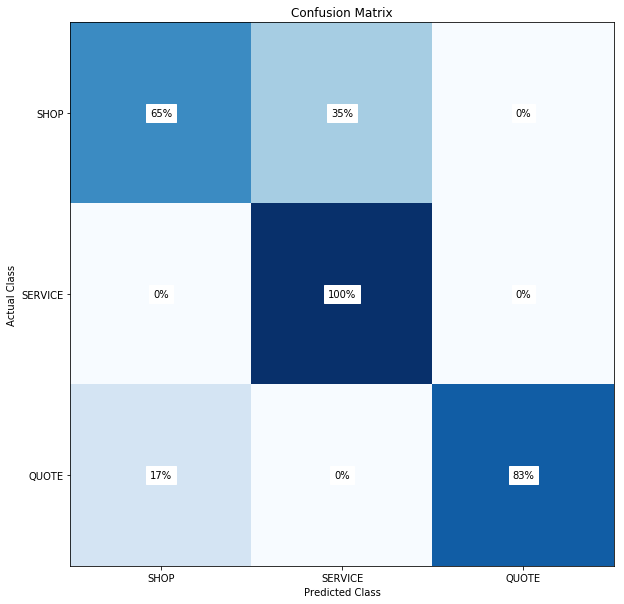

In [13]:
results, metrics_class, metrics_total = test_wcs_model(
        conversation_username=conversation_username,
        conversation_password=conversation_password,
        version=version, 
        workspace_id=workspace_id,
        csvFile='example_data/examples.csv',
        test_only=False,
        clear_existing=True,
        test_ratio=0.5,
        normalize=True)